In [34]:
import pandas as pd
import ast 
import matplotlib.pyplot as plt
import numpy as np

In [35]:
# Open JSON files with article information 
with open("articles.json") as file:
    a = file.readlines()
with open("articles2.json") as file:
    a2 = file.readlines()

# Concatenate the two files
a_con = a+a2    

In [36]:
# Convert the "string JSON" to dictionaries
a_list = []
for item in a_con:
    a_list.append(ast.literal_eval(item))

In [37]:
title_df = pd.DataFrame()
comment_df = pd.DataFrame()
for article in a_list:
    # Extract relevant information from article itself
    title = article["article"]["title"]
    id = article["article"]["id"]
    tag = article["article"]["nodeRef"]["title"]
    total_comments = article["totalComments"]
    # Append to the article DataFrame
    title_df = pd.concat([title_df,pd.DataFrame([{"id":id,"title":title,"tag":tag,"total_comments":total_comments}])],ignore_index=True)

    # Make sure that the article contains comments
    if title_df["total_comments"].iloc[-1]!=0:
        # Get comments
        name = article["article"]["title"]
        df = pd.DataFrame(article["comments"])
        # Drop last name
        df["name"] = df["userIdentity"].apply(lambda x: x["displayName"].split(" ")[0].capitalize())
        df["votes"] = df["votes"].apply(lambda x: x["totalPositiveVotes"])
        df = df.drop(["id","userIdentity","product"],axis=1)
        # Append to comment DataFrame
        comment_df = pd.concat([comment_df,df],ignore_index=True)
# Drop parent information (parent = original comment that is being referenced)
comment_df = comment_df.drop(["parent","parentId"],axis=1)

(array([216.,   0.,   0.,   0.,   0.,   2.,   0.,   0.,   0.,   1.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <BarContainer object of 10 artists>)

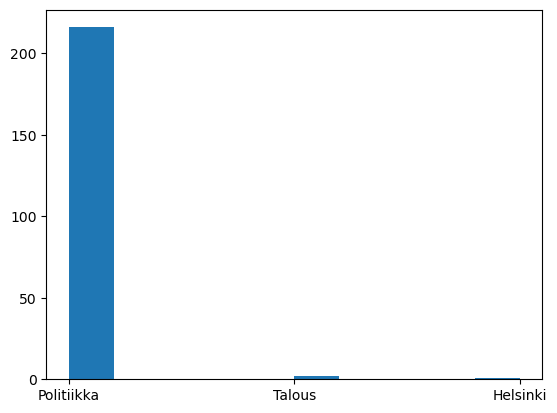

In [38]:
plt.hist(title_df["tag"])

count    219.000000
mean      36.406393
std       30.723451
min        0.000000
25%       14.000000
50%       28.000000
75%       52.500000
max      137.000000
Name: total_comments, dtype: float64


Text(0.5, 1.0, 'Distribution of comments per article')

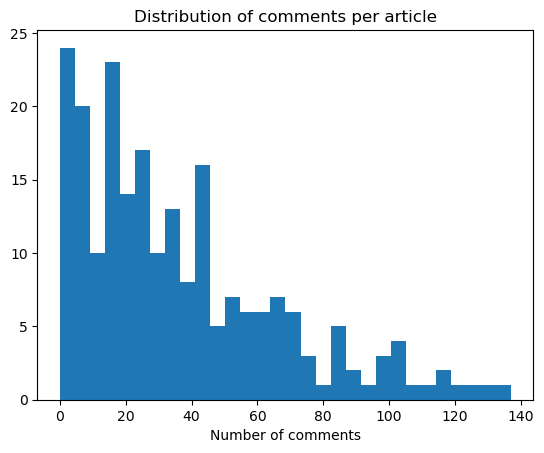

In [39]:
print(title_df["total_comments"].describe())
plt.hist(title_df["total_comments"],bins=30)
plt.xlabel("Number of comments")
plt.title("Distribution of comments per article")

count    7973.000000
mean       93.744011
std       189.904701
min         0.000000
25%         9.000000
50%        28.000000
75%        89.000000
max      2447.000000
Name: votes, dtype: float64


Text(0.5, 1.0, 'Distribution of votes on comments')

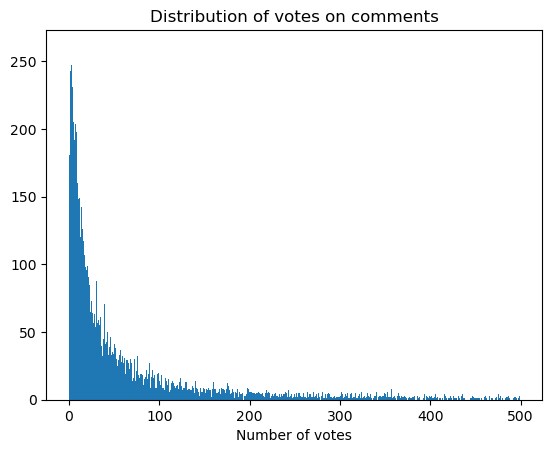

In [40]:
print(comment_df["votes"].describe())
plt.hist(comment_df["votes"],bins=range(0,500))
plt.xlabel("Number of votes")
plt.title("Distribution of votes on comments")

In [41]:
comment_df["len_of_comment"] = comment_df["comment"].apply(lambda x: len(x))

count    7973.000000
mean      460.618713
std       374.907787
min        11.000000
25%       211.000000
50%       351.000000
75%       577.000000
max      2260.000000
Name: len_of_comment, dtype: float64


Text(0.5, 0, 'Length of comment')

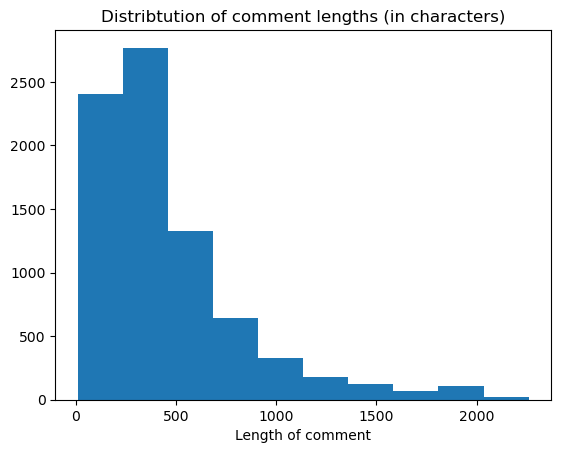

In [42]:
print(comment_df["len_of_comment"].describe())
plt.hist(comment_df["len_of_comment"]);
plt.title("Distribtution of comment lengths (in characters)")
plt.xlabel("Length of comment")

In [43]:
# Creating name list
miehet = pd.read_excel("etunimet.xlsx", sheet_name=0)
naiset = pd.read_excel("etunimet.xlsx", sheet_name=3)
nimet = pd.merge(naiset, miehet, how="outer", on='Etunimi') 
nimet

,Etunimi,Lukumäärä_x,Lukumäärä_y
0,A,21.0,30.0
1,A.,34.0,39.0
2,Aabel,NaN,139.0
3,Aabraham,NaN,68.0
4,Aabram,NaN,17.0
...,...,...,...
22474,Özkan,NaN,9.0
22475,Özlem,21.0,NaN
22476,Ülle,40.0,NaN
22477,Ümit,NaN,21.0


In [44]:
def assign_gender(x):
    # Man = 1, Woman = 0, not known = NaN
    if x["Lukumäärä_x"]>x["Lukumäärä_y"] or np.isnan(x["Lukumäärä_y"]):
        return 0
    elif x["Lukumäärä_x"]<x["Lukumäärä_y"] or np.isnan(x["Lukumäärä_x"]):
        return 1
    return np.nan

# Creating gender column
nimet["Sukupuoli"] = nimet.apply(assign_gender,axis=1)

In [45]:
# Adding gender column
comment_df = pd.merge(comment_df,nimet[["Etunimi","Sukupuoli"]],left_on="name",right_on="Etunimi",how="left").drop(["Etunimi","name"],axis=1)

In [46]:
# Lowercasing words
comment_df["comment"] = comment_df["comment"].str.lower()

In [47]:
# Removing br-tags
comment_df['comment'] = comment_df['comment'].str.replace(r'<br>|</br>', ' ', regex=True)
# Removing punctuation
#comment_df['comment'] = comment_df['comment'].str.replace(r'[^\w\s]+', '', regex=True)

In [15]:
# with open("stopwords-fi.txt") as f:
#     stopwords = set(f.read().split("\n"))

# # Removing stop-words
# comment_df['comment'] = comment_df['comment'].apply(lambda x: ' '.join([word for word in str(x).split() if word not in (stopwords)]))

In [16]:
# from nltk.stem.snowball import SnowballStemmer

# stemmer = SnowballStemmer("finnish")

# print(" ".join(stemmer.stem(w) for w in comment_df['comment'].iloc[0].split()))

miel lapsuud vitivalko turk pukeutun ruotsalaissotil märkäjärvellä. evl.dyrssen vapaaehtoisjouko sotur ottiv rintamavastu pohjois suome rajoilla, ilmavoimineen, obs!


In [48]:
# Use a pipeline as a high-level helper
from transformers import pipeline

pipe = pipeline("text-classification", model="fergusq/finbert-finnsentiment")

# # Load model directly
# from transformers import AutoTokenizer, AutoModelForSequenceClassification

# tokenizer = AutoTokenizer.from_pretrained("fergusq/finbert-finnsentiment")
# model = AutoModelForSequenceClassification.from_pretrained("fergusq/finbert-finnsentiment")

c:\Users\joona\anaconda3\envs\project_data\Lib\site-packages\huggingface_hub\file_download.py:1142: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [49]:
# print("En voi ymmärtää...",pipe("En voi ymmärtää...")[0])
# print("En voi ymmärtää",pipe("En voi ymmärtää")[0])
# print("En voi ymmärtää!",pipe("En voi ymmärtää!")[0])
# print("En voi ymmärtää!!!",pipe("En voi ymmärtää!!!")[0])
# print("EN VOI YMMÄRTÄÄ!!!",pipe("EN VOI YMMÄRTÄÄ!!!")[0])

In [ ]:
# The number of tokens was too high for a certain comment
# Here we find the longest comment (number of words)
max_len = comment_df["comment"].str.split().apply(lambda x: len(x)).max()
# Find index corresponding to this longest comment
idx = comment_df["comment"][comment_df["comment"].str.split().apply(lambda x: len(x))==max_len]
# Drop the troublesome comment
comment_df2 = comment_df.drop(index=idx)

In [111]:
%%time
comment_df2["sentiment"] = comment_df2["comment"].apply(lambda x: pipe(inputs=x)[0]["label"])

CPU times: total: 2h 53s
Wall time: 52min 3s


In [113]:
comment_df2.to_csv("comment.csv")